To Do:
- Unificar arquivos
- Checar score de acordo com a classe
- Usar métricas de número de caracteres de tweets nas análises de ofensas
- Analisar tweets repetidos mais a fundo (possiveis bots)
- Testes de hipóteses para diferença de médias entre categorias
- Comparar resultados entre eleitos e não eleitos


Avaliar fatores de impacto nos tweets
- Que tipo de conteúdo resulta em mais engajamento (positivo ou negativo)?
- Que tipo de conteúdo resulta em mais conteúdo ofensivo
- Desenhar grafo de interações (https://towardsdatascience.com/social-network-analysis-from-theory-to-applications-with-python-d12e9a34c2c7)


Desenhar timeline do projeto na apresentação
  

# Carregando e preparando dados

In [1]:
from datetime import datetime
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
from scipy import stats 
from scipy.stats import ttest_1samp, ttest_ind
import seaborn as sns
import sys
import tabulate
from tqdm import tqdm

sys.path.append("../")
pd.options.display.max_colwidth = 50
sns.set_style("whitegrid")

In [2]:
candidates_file_path = "../data/processed/se_candidates_output_3.csv"
raw_cand_df = pd.read_csv(candidates_file_path, sep=";", encoding="utf-8")

print(raw_cand_df.shape)
raw_cand_df.info()

(1250, 79)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 79 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DT_GERACAO                     1250 non-null   object 
 1   HH_GERACAO                     1250 non-null   object 
 2   ANO_ELEICAO                    1250 non-null   int64  
 3   CD_TIPO_ELEICAO                1250 non-null   int64  
 4   NM_TIPO_ELEICAO                1250 non-null   object 
 5   NR_TURNO                       1250 non-null   int64  
 6   CD_ELEICAO                     1250 non-null   int64  
 7   DS_ELEICAO                     1250 non-null   object 
 8   DT_ELEICAO                     1250 non-null   object 
 9   TP_ABRANGENCIA                 1250 non-null   object 
 10  SG_UF                          1250 non-null   object 
 11  SG_UE                          1250 non-null   object 
 12  NM_UE                          1250 n

In [3]:
est_tweets_file_path = (
    "../data/processed/sp_elected_stdep_tweets-ft_hf_classified.csv"
)
est_raw_tweets_df = pd.read_csv(est_tweets_file_path, sep=";", encoding="utf-8")

print(est_raw_tweets_df.shape)
est_raw_tweets_df.info()

(46973, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46973 entries, 0 to 46972
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   url                       46973 non-null  object 
 1   date                      46973 non-null  object 
 2   content                   46973 non-null  object 
 3   user                      46973 non-null  object 
 4   reply_count               46973 non-null  int64  
 5   retweet_count             46973 non-null  int64  
 6   like_count                46973 non-null  int64  
 7   quote_count               46973 non-null  int64  
 8   in_reply_to_id            43445 non-null  float64
 9   in_reply_to_user          43328 non-null  object 
 10  conversation_id           46973 non-null  object 
 11  conversation_user         46973 non-null  object 
 12  ru_bert_base_label        46973 non-null  bool   
 13  ru_bert_base_score        46973 non-null  float64

In [4]:
fed_tweets_file_path = (
    "../data/processed/sp_elected_feddep_tweets-ft_hf_classified.parquet"
)
fed_raw_tweets_df = pd.read_parquet(fed_tweets_file_path)

print(fed_raw_tweets_df.shape)
fed_raw_tweets_df.info()

(78193, 22)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 78193 entries, 220 to 215619
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   id                        78193 non-null  object             
 1   date                      78193 non-null  datetime64[ns, UTC]
 2   user                      78193 non-null  object             
 3   content                   78193 non-null  object             
 4   in_reply_to_id            75049 non-null  object             
 5   in_reply_to_user          74540 non-null  object             
 6   conversation_id           78193 non-null  object             
 7   conversation_user         78193 non-null  object             
 8   reply_count               78193 non-null  int64              
 9   retweet_count             78193 non-null  int64              
 10  like_count                78193 non-null  int64              
 11  

In [5]:
# Mantendo cópia dos datasets iniciais
cand_df = raw_cand_df
est_tts_df = est_raw_tweets_df
fed_tts_df = fed_raw_tweets_df

In [6]:
print(sorted(est_tts_df.columns))
print(sorted(fed_tts_df.columns))

['ci_distilbert_base_label', 'ci_distilbert_base_score', 'content', 'conversation_id', 'conversation_user', 'date', 'ft_rc_bert_base_label', 'ft_rc_bert_base_score', 'in_reply_to_id', 'in_reply_to_user', 'label_sum', 'like_count', 'quote_count', 'reply_count', 'retweet_count', 'ru_bert_base_label', 'ru_bert_base_score', 'ru_bert_large_label', 'ru_bert_large_score', 'ru_mdeberta_base_label', 'ru_mdeberta_base_score', 'url', 'user']
['cl_distilbert_base_label', 'cl_distilbert_base_score', 'content', 'conversation_id', 'conversation_user', 'date', 'ft_rc_bert_base_label', 'ft_rc_bert_base_score', 'id', 'in_reply_to_id', 'in_reply_to_user', 'label_sum', 'like_count', 'quote_count', 'rc_bert_base_label', 'rc_bert_base_score', 'rc_mdeberta_base_label', 'rc_mdeberta_base_score', 'reply_count', 'retweet_count', 'user', 'view_count']


## Dataset de Candidatos

In [7]:
# Removendo colunas não utilizadas
cand_cols = [
    "SG_UF",
    "DS_CARGO",
    "SQ_CANDIDATO",
    "NM_URNA_CANDIDATO",
    "NR_PARTIDO",
    "SG_PARTIDO",
    "NM_MUNICIPIO_NASCIMENTO",
    "NR_IDADE_DATA_POSSE",
    "DS_GENERO",
    "DS_GRAU_INSTRUCAO",
    "DS_ESTADO_CIVIL",
    "DS_COR_RACA",
    "DS_OCUPACAO",
    "DS_SIT_TOT_TURNO",
    "ST_REELEICAO",
    "TW_USER",
    "TW_followersCount",
    "TW_friendsCount",
    "TW_statusesCount",
    "TW_favouritesCount",
]
cand_df = cand_df[cand_cols]
print(cand_df.shape)

(1250, 20)


In [8]:
# Filtrando somente os deputados estaduais de SP
cand_df = cand_df[cand_df["SG_UF"] == "SP"]
cand_df = cand_df[(cand_df["DS_CARGO"] == "DEPUTADO ESTADUAL") | (cand_df["DS_CARGO"] == "DEPUTADO FEDERAL")]
cand_df.shape

(595, 20)

In [9]:
# Convertendo usernames para minusculo
cand_df["TW_USER"] = cand_df["TW_USER"].str.lower()

In [10]:
# Salvando arquivos consolidado
output_path = "../data/processed/"
file_name = 'sp_elected_est_fed_dep_candidates'
output_suffix = "analysis"
file_format = 'parquet'

output_file = f"{output_path}{file_name}-{output_suffix}.{file_format}"
print(output_file)

cand_df.to_parquet(output_file)

../data/processed/sp_elected_est_fed_dep_candidates-analysis.parquet


## Dataset de Tweets

In [11]:
est_tts_df.url[0].split('/')[-1]

'1575873686019579905'

In [12]:
def extract_id_from_url(url):
    return url.split('/')[-1]

def convert_url_to_tweet_id(df):
    if 'url' not in df.columns:
        return df
    df['id'] = df['url'].apply(extract_id_from_url)
    return df

if not 'id' in est_tts_df:
    convert_url_to_tweet_id(est_tts_df)

if not 'id' in fed_tts_df:
    convert_url_to_tweet_id(fed_tts_df)

In [13]:
# Removendo colunas não utilizadas. Vamos usar somente a classificação do modelo refinado.
tweet_cols = [
    "id",
    "date",
    "content",
    "user",
    "in_reply_to_user",
    "conversation_user",
    "ft_rc_bert_base_label",
    "ft_rc_bert_base_score",
]
est_tts_df = est_tts_df[tweet_cols]
fed_tts_df = fed_tts_df[tweet_cols]
print(est_tts_df.shape, fed_tts_df.shape)

(46973, 8) (78193, 8)


In [14]:
tts_df = pd.concat([est_tts_df, fed_tts_df])
tts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125166 entries, 0 to 215619
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     125166 non-null  object 
 1   date                   125166 non-null  object 
 2   content                125166 non-null  object 
 3   user                   125166 non-null  object 
 4   in_reply_to_user       117868 non-null  object 
 5   conversation_user      125166 non-null  object 
 6   ft_rc_bert_base_label  125166 non-null  bool   
 7   ft_rc_bert_base_score  125166 non-null  float64
dtypes: bool(1), float64(1), object(6)
memory usage: 7.8+ MB


In [15]:
tts_df.rename(columns={
    "ft_rc_bert_base_label": "class_label", 
    "ft_rc_bert_base_score": "class_score"
}, inplace=True)

In [16]:
# Convertendo a coluna de data para o tipo correto
tts_df.date = pd.to_datetime(tts_df.date)
tts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125166 entries, 0 to 215619
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   id                 125166 non-null  object             
 1   date               125166 non-null  datetime64[ns, UTC]
 2   content            125166 non-null  object             
 3   user               125166 non-null  object             
 4   in_reply_to_user   117868 non-null  object             
 5   conversation_user  125166 non-null  object             
 6   class_label        125166 non-null  bool               
 7   class_score        125166 non-null  float64            
dtypes: bool(1), datetime64[ns, UTC](1), float64(1), object(5)
memory usage: 7.8+ MB


In [17]:
# Filtrando somente os tweets do período desejado
local_tz = pytz.timezone("America/Sao_Paulo")
since = datetime(year=2022, month=9, day=1, tzinfo=local_tz)
until = datetime(year=2022, month=11, day=1, tzinfo=local_tz)

tts_df = tts_df[(tts_df["date"] >= since) & (tts_df["date"] <= until)]
tts_df.shape

(125166, 8)

In [18]:
# Removendo tweets com informação faltando de reply
# Se 'user' é diferente de 'conversation_user', então o tweet deveria ter também 'in_reply_to_user'
# Se não tiver, é por que houve algum erro durante o scraping, ou com o tweet respondido
tts_df = tts_df[
    ~(
        (tts_df["in_reply_to_user"].isnull())
        & (tts_df["user"] != tts_df["conversation_user"])
    )
]
tts_df.shape

(125112, 8)

In [19]:
# Convertendo usernames para minusculo
tts_df.user = tts_df.user.str.lower()
tts_df.conversation_user = tts_df.conversation_user.str.lower()
tts_df.in_reply_to_user = tts_df.in_reply_to_user.str.lower()

## Juntando os datasets

In [20]:
df = pd.merge(
    tts_df, cand_df, left_on="conversation_user", right_on="TW_USER", how="left"
)
print(df.shape)
df.info()

(125112, 28)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 125112 entries, 0 to 125111
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   id                       125112 non-null  object             
 1   date                     125112 non-null  datetime64[ns, UTC]
 2   content                  125112 non-null  object             
 3   user                     125112 non-null  object             
 4   in_reply_to_user         117868 non-null  object             
 5   conversation_user        125112 non-null  object             
 6   class_label              125112 non-null  bool               
 7   class_score              125112 non-null  float64            
 8   SG_UF                    125112 non-null  object             
 9   DS_CARGO                 125112 non-null  object             
 10  SQ_CANDIDATO             125112 non-null  int64              
 11  

In [21]:
# Adicionando coluna para indicar se o usuário do tweet é um candidato
deputies_usernames = list(df.TW_USER.str.lower().unique())
df["user_is_candidate"] = df["user"].apply(lambda u: u in deputies_usernames)

In [22]:
# Salvando arquivos consolidado
output_path = "../data/processed/"
file_name = 'sp_elected_est_fed_dep_tweets'
output_suffix = "analysis"
file_format = 'parquet'

output_file = f"{output_path}{file_name}-{output_suffix}.{file_format}"
print(output_file)

df.to_parquet(output_file)

../data/processed/sp_elected_est_fed_dep_tweets-analysis.parquet


# EDA

## Exploração inicial dos dados

[Text(0.5, 1.0, 'Histograma de caracteres por tweet')]

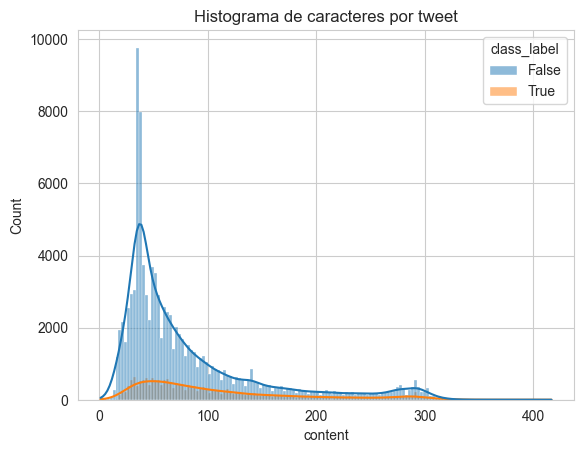

In [23]:
# Checando a distribuição do tamanho dos tweets
sns.histplot(
    df,
    x=df.content.str.len(),
    hue='class_label',
    multiple='layer',
    kde=True,
).set(title="Histograma de caracteres por tweet")

[Text(0.5, 1.0, 'Histograma de caracteres - Tweets sem conteúdo ofensivo')]

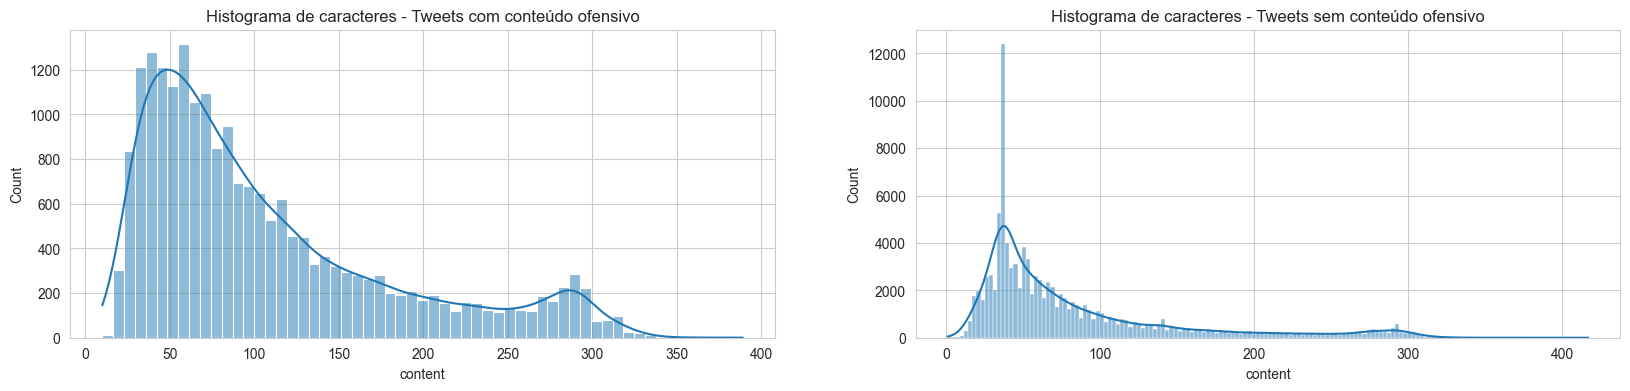

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4))

of_df = df[df['class_label'] == True]
sns.histplot(
    of_df,
    x=of_df.content.str.len(),
    kde=True,
    ax=ax[0],
).set(title="Histograma de caracteres - Tweets com conteúdo ofensivo")

nof_df = df[df['class_label'] == False]
sns.histplot(
    nof_df,
    x=nof_df.content.str.len(),
    kde=True,
    ax=ax[1],
).set(title="Histograma de caracteres - Tweets sem conteúdo ofensivo")

False    0.926218
True     0.073782
Name: user_is_candidate, dtype: float64


[Text(0.5, 1.0, 'Proporção de tweets por candidato')]

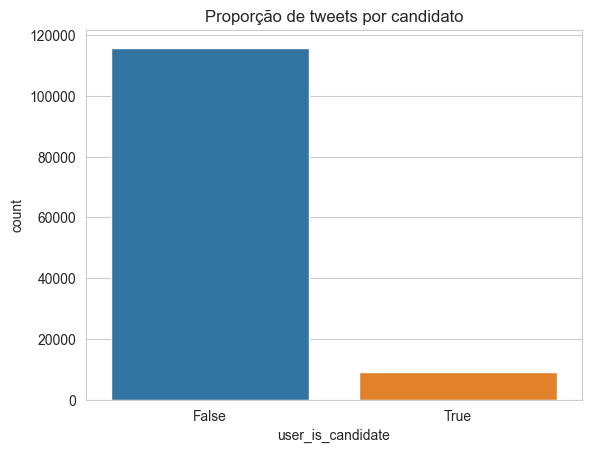

In [25]:
# Avaliando a proporção de tweets entre candidatos e não-candidatos
print(df["user_is_candidate"].value_counts(normalize=True))

sns.countplot(
    df,
    x="user_is_candidate", 
    # ax=ax[1]
).set(title="Proporção de tweets por candidato")

In [26]:
# Avaliando a distribuição dos tweets entre os candidatos
print(f"df['conversation_user'] mais comuns: \n{(df['conversation_user'].value_counts(normalize=True)[:10])}\n")
print(f"df['user'] mais comuns: \n{(df['user'].value_counts(normalize=True)[:10])}\n")

df['conversation_user'] mais comuns: 
samiabomfim        0.315094
carteiroreaca      0.155077
rsallesmma         0.123170
andreawerner_      0.094819
luizaerundina      0.067220
marcofeliciano     0.053744
esuplicy           0.051242
pauloteixeira13    0.045016
leosiqueirabr      0.021701
carlosgiannazi     0.011821
Name: conversation_user, dtype: float64

df['user'] mais comuns: 
andreawerner_      0.009320
samiabomfim        0.006650
rosangelamorosp    0.005315
carteiroreaca      0.004916
carlosgiannazi     0.004108
bfeministapsol     0.003229
julianapt          0.003165
leosiqueirabr      0.003109
valbolsonaro       0.002542
luizaerundina      0.002286
Name: user, dtype: float64



~60% dos tweets analisados foram postados em threads de apenas 3 candidatos, indicando um alto desbalanceamento entre os tweets dos deputados.
Porém quando avaliamos os usuários que mais postaram, os 3 usuários mais ativos representam apenas ~3% dos tweets.

False    0.831951
True     0.168049
Name: class_label, dtype: float64 



[Text(0.5, 1.0, 'Histograma de score das classificações')]

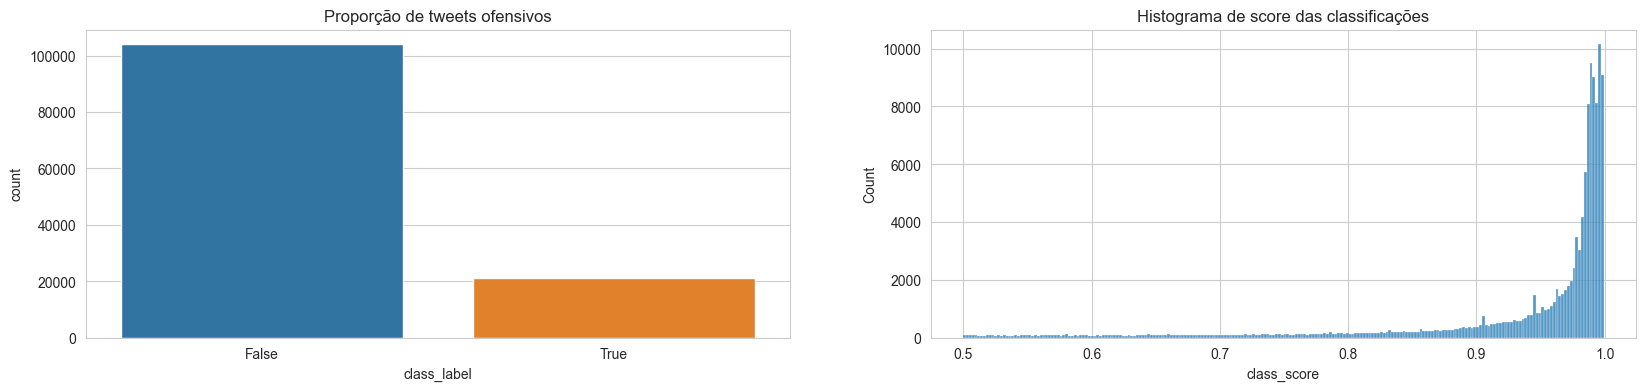

In [27]:
# Avaliando a distribuição e score de ofensas no dataset
print(df['class_label'].value_counts(normalize=True), '\n')

fig, ax = plt.subplots(1, 2, figsize=(20, 4))
sns.countplot(
    df,
    x="class_label", 
    ax=ax[0],
).set(title="Proporção de tweets ofensivos")
sns.histplot(
    df.class_score,
    ax=ax[1],
).set(title="Histograma de score das classificações")

Aproximadamente 17% dos tweets analisados receberam a flag de conteúdo ofensivo

In [28]:
# Checando tweets com conteúdo igual, que acontece principalmente em dois cenários:
# - Vários usuários postando exatamente a mesma mensagem para um candidato
# - Um usuário postando exatamente a mesma mensagem para vários candidatos diferentes
repeated_tweets = (df.content.value_counts() > 1).loc[lambda x: x == True].index
repeated_tweets = df[df['content'].isin(repeated_tweets)]
indexes = repeated_tweets.content.sort_values().index
repeated_tweets = repeated_tweets.reindex(indexes)

print(f'Tweets de conteúdo repetido: {repeated_tweets.shape[0]}')
print(f'Proporção de tweets repetidos: {repeated_tweets.shape[0] / df.shape[0]}')

print(f'\nProporção de conteúdo ofensivo nos tweets repetidos: \n{repeated_tweets["class_label"].value_counts(normalize=True)}')

Tweets de conteúdo repetido: 7162
Proporção de tweets repetidos: 0.05724470874096809

Proporção de conteúdo ofensivo nos tweets repetidos: 
False    0.826864
True     0.173136
Name: class_label, dtype: float64


A proporção de tweets com conteúdo repetido e ofensivo é semelhante à encontrada no total de tweets

## Calculando e analisando métricas

**Glossário**
- **tweet**: qualquer postagem feita no Twitter
- **reply**: tweets feitos em resposta direta a outro *tweet*
- **thread** (conversa): uma sequencia de *tweets*, composta pelo *tweet* inicial, *replies* feitas a esse *tweet*, *replies* feitas a essas *replies*, e assim sucessivamente

### Funções auxiliares
Vamos começar definindo algumas funções para padronizar e facilitar a nossa análise

In [29]:
figsize = (20, 4)
percentiles = [0.05, 0.25, 0.5, 0.75, 0.95]
base_cols = ['TW_USER']

def side_by_side(*dfs):
    """Exibe dataframes lado a lado"""
    html = '<div style="display:flex">'
    for df in dfs:
        html += '<div style="margin-right: 2em">'
        html += df.to_html()
        html += '</div>'
    html += '</div>'
    display(HTML(html))

def print_quant_data(df, cols, sort_by):
    """Exibe lado a lado as descrições estatísticas das colunas, e os 10 maiores valores de coluna passada"""
    side_by_side(
        df[cols].describe(percentiles=percentiles),
        df[base_cols + cols].sort_values(sort_by, ascending=False).head(10)
    )

def plot_histograms(df, cols, figsize=figsize):
    """Plota histogramas das colunas passadas lado a lado"""
    fig, ax = plt.subplots(1, len(cols), figsize=figsize)
    
    for i, col in enumerate(cols):
        sns.histplot(
            df,
            x=col,
            kde=True,
            ax=ax[i],
        ).set(title=f'Histograma de {col}')  

def plot_boxplots(df, cols, figsize=figsize, title='Métricas'):
    """Plota boxplots das colunas passadas um acima do outro"""
    plt.figure(figsize=figsize)
    sns.boxplot(
        data=df[cols],
        orient='h',
    ).set(title=title)
    
def plot_cols(df, cols, figsize=figsize, title='Métricas'):
    """Plota histogramas e boxplots das colunas passadas"""
    plot_histograms(df, cols, figsize)
    plt.show()
    plot_boxplots(df, cols, figsize, title)


def plot_corr_heatmap(df, figsize=(12, 4)):
    plt.figure(figsize=figsize)
    sns.heatmap(
        df.corr(),
        annot=True, fmt='.2f',
        cmap='PRGn', vmin=-1, vmax=1,
        mask=np.triu(np.ones_like(df.corr()))
    )
    

### Métricas de atividade e engajamento

In [30]:
def get_tweets(user):
    """Total de tweets postados pelo usuário"""
    _df = df[df['user'] == user]
    return _df.shape[0]

def get_threads(user):
    """Total de threads criadas pelo usuário"""
    _df = df[df['user'] == user]
    threads = _df[_df['in_reply_to_user'].isna()]
    return threads.shape[0]

def get_replies(user):
    """Total de replies recebidas pelo usuário"""
    _df = df[df['in_reply_to_user'] == user]
    return _df.shape[0]

def get_thread_tts(user):
    """Total de tweets postados em threads do usuário (incluindo os próprios tweets do usuario)"""
    _df = df[df['conversation_user'] == user]
    return _df.shape[0]

cand_df['TW_tweets'] = cand_df['TW_USER'].apply(get_tweets)
cand_df['TW_threads'] = cand_df['TW_USER'].apply(get_threads)
cand_df['TW_replies'] = cand_df['TW_USER'].apply(get_replies)
cand_df['TW_thread_tts'] = cand_df['TW_USER'].apply(get_thread_tts)

direct_activity_cols = ['TW_tweets', 'TW_threads', 'TW_replies', 'TW_thread_tts',]

side_by_side(
    cand_df[direct_activity_cols].describe(percentiles=percentiles),
    cand_df[['TW_USER'] + direct_activity_cols].sort_values('TW_thread_tts', ascending=False).head(10)
)

,TW_tweets,TW_threads,TW_replies,TW_thread_tts
count,595.000000,595.000000,595.000000,595.000000
mean,15.781513,12.174790,196.168067,210.272269
std,84.389345,62.100898,1991.229068,2045.490857
min,0.000000,0.000000,0.000000,0.000000
5%,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
95%,77.900000,73.100000,17.200000,116.000000
max,1166.000000,660.000000,38630.000000,39422.000000


In [31]:
# Muitos candidatos não fizeram nenhuma postagem, portanto vamos remove-los e avaliar os números novamente
cand_df = cand_df[cand_df['TW_threads'] > 0]
print(cand_df.shape)

(47, 24)


,TW_tweets,TW_threads,TW_replies,TW_thread_tts
count,47.000000,47.000000,47.000000,47.000000
mean,196.404255,154.127660,2482.617021,2661.957447
std,236.108731,165.665144,6737.989861,6881.892235
min,1.000000,1.000000,0.000000,1.000000
5%,5.300000,4.600000,0.300000,7.900000
25%,39.000000,30.000000,4.000000,91.000000
50%,125.000000,102.000000,44.000000,154.000000
75%,243.500000,197.500000,525.500000,791.500000
95%,650.000000,519.000000,13880.200000,14345.900000
max,1166.000000,660.000000,38630.000000,39422.000000


,TW_USER,TW_tweets
861,andreawerner_,1166
234,samiabomfim,832
1093,rosangelamorosp,665
734,carteiroreaca,615
679,carlosgiannazi,514
,TW_USER,TW_threads
234,samiabomfim,660
1093,rosangelamorosp,636
861,andreawerner_,525
734,carteiroreaca,505


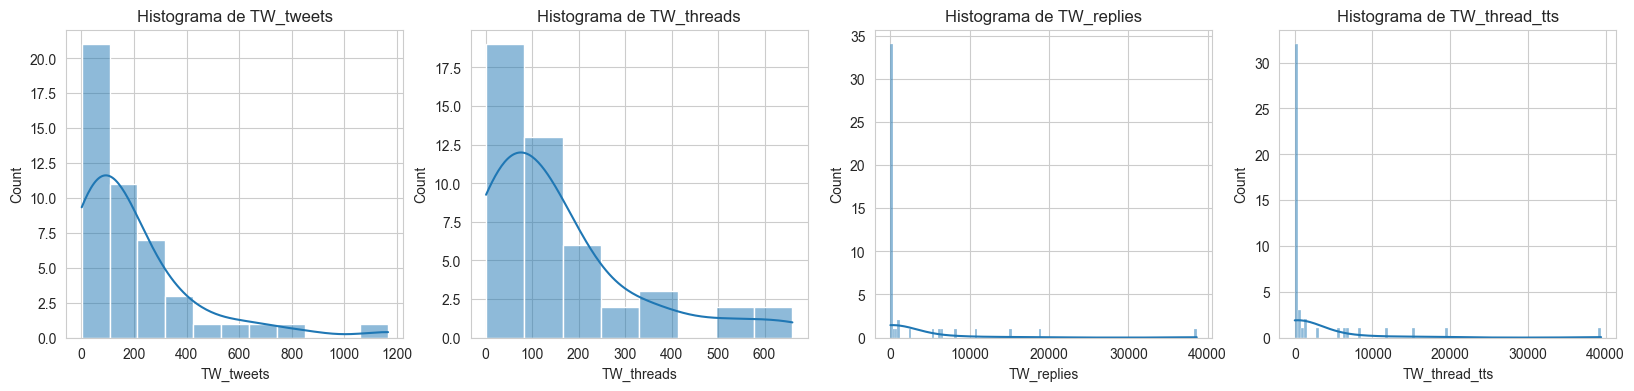

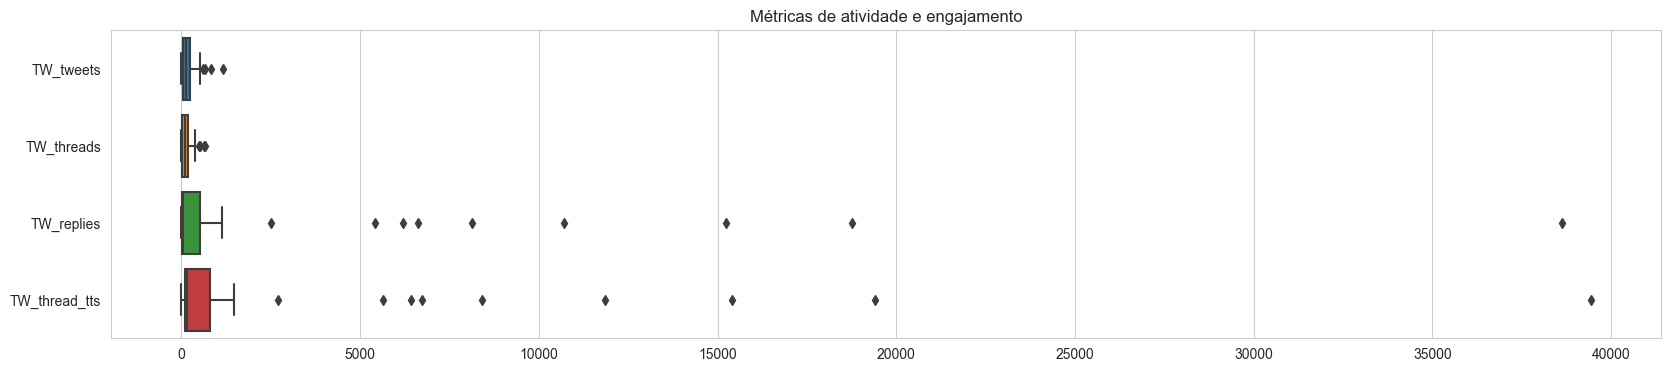

In [32]:
print_quant_data(cand_df, direct_activity_cols, 'TW_thread_tts')

side_by_side(
    cand_df[['TW_USER', 'TW_tweets']].sort_values('TW_tweets', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_threads']].sort_values('TW_threads', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_replies']].sort_values('TW_replies', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_thread_tts']].sort_values('TW_thread_tts', ascending=False).head(5),
)

plot_cols(cand_df, direct_activity_cols, title=f'Métricas de atividade e engajamento')

Podemos perceber alguns outliers nas quatro métricas, mas as diferenças são bem mais acentuadas em `TW_replies` e `TW_thread_tts`. Isso nos mostra que o engajamento recebido pelos usuarios pode ser bastante desigual e irregular, e é provável que isso impacte nas métricas de conteúdo ofensivo.

Além disso, a coluna `TW_replies` tem valores muito próximos de `TW_thread_tts`, indicando que as threads sejam pouco profundas (ou seja, possuem poucos níveis de replies) e que a grande maioria dos tweets são respostas diretas à quem iniciou as threads.

Vamos analisar melhor a composição das threads para confirmar estas suposições:

### Métricas de composição das threads

In [33]:
def get_user_thread_tts(user):
    """Total de tweets postados pelo usuário em suas threads"""
    _df = df[
        (df['conversation_user'] == user) & 
        (df['user'] == user)
    ]
    return _df.shape[0]

def get_reply_thread_tts(user):
    """Total de replies ao usuário, em threads do usuário"""
    _df = df[
        (df['conversation_user'] == user) & 
        (df['in_reply_to_user'] == user) & 
        (df['user'] != user)
    ]
    return _df.shape[0]
    
def get_non_reply_thread_tts(user):
    """Total de tweets postados em threads do usuário, mas que não envolvem o usuário diretamente"""
    _df = df[
        (df['conversation_user'] == user) & 
        (df['in_reply_to_user'] != user) & 
        (df['user'] != user)
    ]
    return _df.shape[0]

cand_df['TW_user_thread_tts'] = cand_df['TW_USER'].apply(get_user_thread_tts)
cand_df['TW_reply_thread_tts'] = cand_df['TW_USER'].apply(get_reply_thread_tts)
cand_df['TW_non_reply_thread_tts'] = cand_df['TW_USER'].apply(get_non_reply_thread_tts)

thread_comp_cols = ['TW_user_thread_tts', 'TW_reply_thread_tts', 'TW_non_reply_thread_tts']

,TW_user_thread_tts,TW_reply_thread_tts,TW_non_reply_thread_tts
count,47.000000,47.000000,47.000000
mean,195.510638,2462.106383,4.340426
std,235.131404,6732.128558,11.986000
min,1.000000,0.000000,0.000000
5%,5.300000,0.000000,0.000000
25%,39.000000,1.000000,0.000000
50%,125.000000,25.000000,0.000000
75%,243.500000,483.000000,0.500000
95%,649.700000,13864.500000,33.700000
max,1163.000000,38567.000000,59.000000


,TW_USER,TW_user_thread_tts
861,andreawerner_,1163
234,samiabomfim,821
1093,rosangelamorosp,665
734,carteiroreaca,614
679,carlosgiannazi,514
,TW_USER,TW_reply_thread_tts
234,samiabomfim,38567
734,carteiroreaca,18755
994,rsallesmma,15246
861,andreawerner_,10641


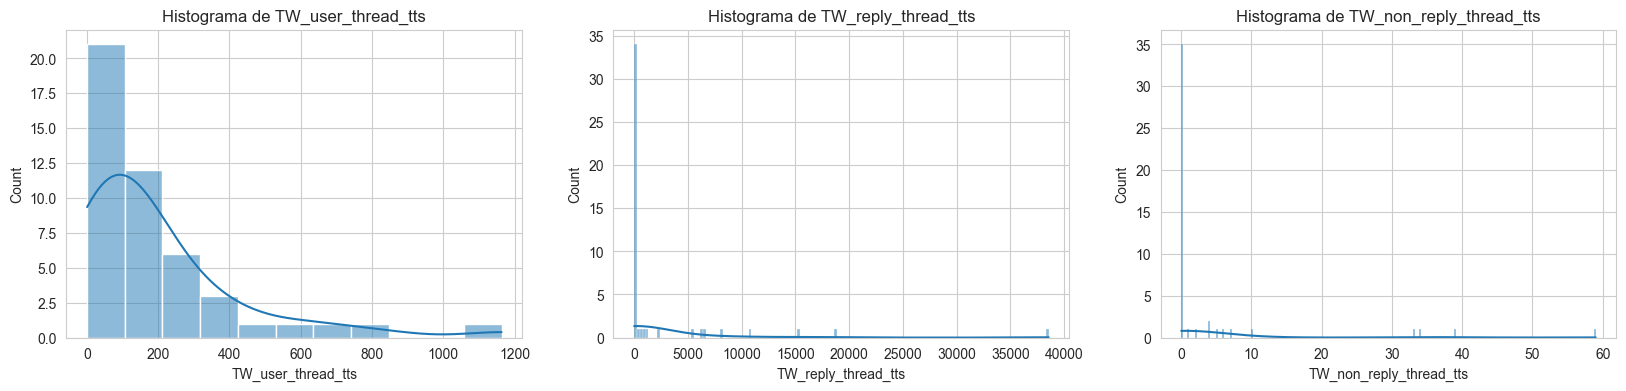

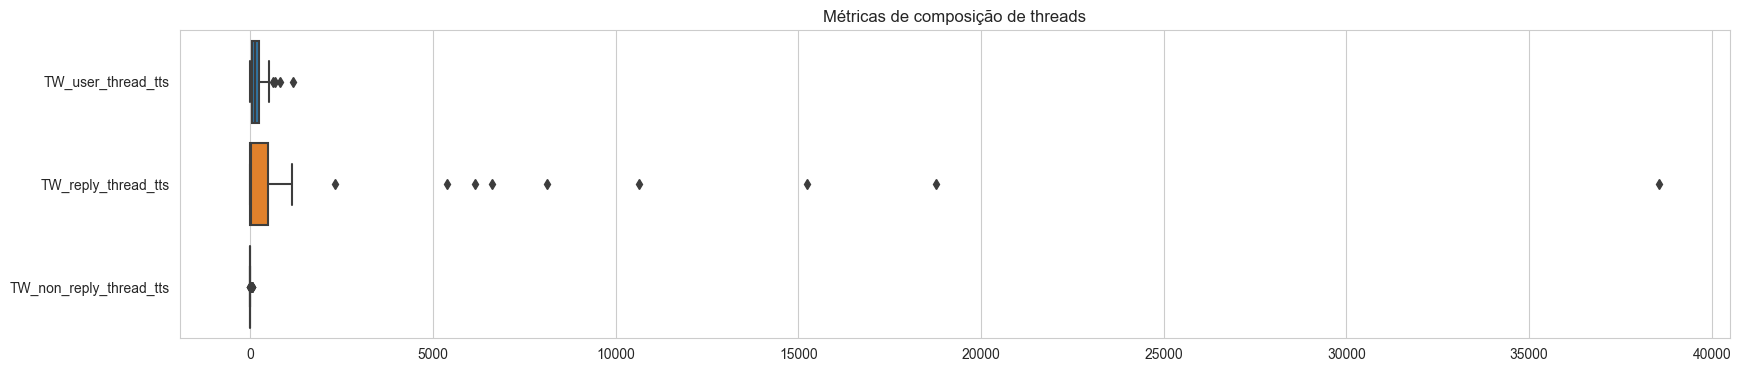

In [34]:
print_quant_data(cand_df, thread_comp_cols, 'TW_non_reply_thread_tts')

side_by_side(
    cand_df[['TW_USER', 'TW_user_thread_tts']].sort_values('TW_user_thread_tts', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_reply_thread_tts']].sort_values('TW_reply_thread_tts', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_non_reply_thread_tts']].sort_values('TW_non_reply_thread_tts', ascending=False).head(5),
)

plot_cols(cand_df, thread_comp_cols, title=f'Métricas de composição de threads')

In [35]:
# Vamos checar a proporção de tipo de tweet em nosso dataset
means_sum = sum(cand_df[thread_comp_cols].mean())
cand_df[thread_comp_cols].mean() / means_sum

TW_user_thread_tts         0.073446
TW_reply_thread_tts        0.924923
TW_non_reply_thread_tts    0.001631
dtype: float64

Estes números confirmam que a grande maioria dos tweets são respostas diretas aos criadores das threads, e portanto podemos ignorar os tweets que não envolvem os criadores de threads: 
- **~7%:** tweets dos criadores das threads
- **~92%:** replies diretas aos criadores das threads
- **~0.01%:** replies que não envolvem os criadores das threads

Antes de seguir com as análises de conteúdo ofensivo, vamos calcular também algumas taxas relacionadas ao engajamento

### Métricas proporcionais de engajamento

In [36]:
"""
Média de tweets do usuario por threads do usuário. 
Indica o quanto o usuario interage com outros tweets dentro de suas threads
"""
cand_df['TW_avg_thread_user_tts'] = cand_df['TW_tweets'] / cand_df['TW_threads']

"""
Média de tweets do usuario pelo total de tweets em suas threads. 
Indica o quanto do engajamento das threads vem do próprio usuário
"""
cand_df['TW_avg_thread_part'] = cand_df['TW_tweets'] / cand_df['TW_thread_tts']

"""
Média de replies que o usuário recebe para cada tweet postado.
Indica se o usuário recebe um alto engajamento direto
"""
cand_df['TW_avg_replies'] = cand_df['TW_replies'] / cand_df['TW_tweets']

"""
Média do total de tweets por thread do usuário.
Indica o engajamento geral nas threads do usuário
"""
cand_df['TW_avg_thread_tts'] = cand_df['TW_thread_tts'] / cand_df['TW_threads']

prop_activity_cols = ['TW_avg_thread_user_tts', 'TW_avg_thread_part', 'TW_avg_replies', 'TW_avg_thread_tts']

,TW_avg_thread_user_tts,TW_avg_thread_part,TW_avg_replies,TW_avg_thread_tts
count,47.000000,47.000000,47.000000,47.000000
mean,1.236015,0.607527,8.311138,11.346723
std,0.381123,0.372354,21.550712,25.807641
min,1.000000,0.008112,0.000000,1.000000
5%,1.000000,0.024283,0.001389,1.001395
25%,1.005338,0.309286,0.080128,1.083916
50%,1.139442,0.628319,0.666667,1.786667
75%,1.248762,0.990789,2.543885,4.395238
95%,1.887121,1.000000,41.655836,53.337153
max,3.039062,1.007937,121.976000,151.078431


,TW_USER,TW_avg_thread_user_tts
1015,leosiqueirabr,3.039062
861,andreawerner_,2.220952
947,lcmarcolino,1.916667
186,rafaelsaraivasp,1.818182
1019,felipebecari,1.780000
,TW_USER,TW_avg_thread_part
911,rfalcao13,1.007937
16,pauloabarbosa,1.000000
429,falecomvinicius,1.000000
155,kikoceleguim,1.000000


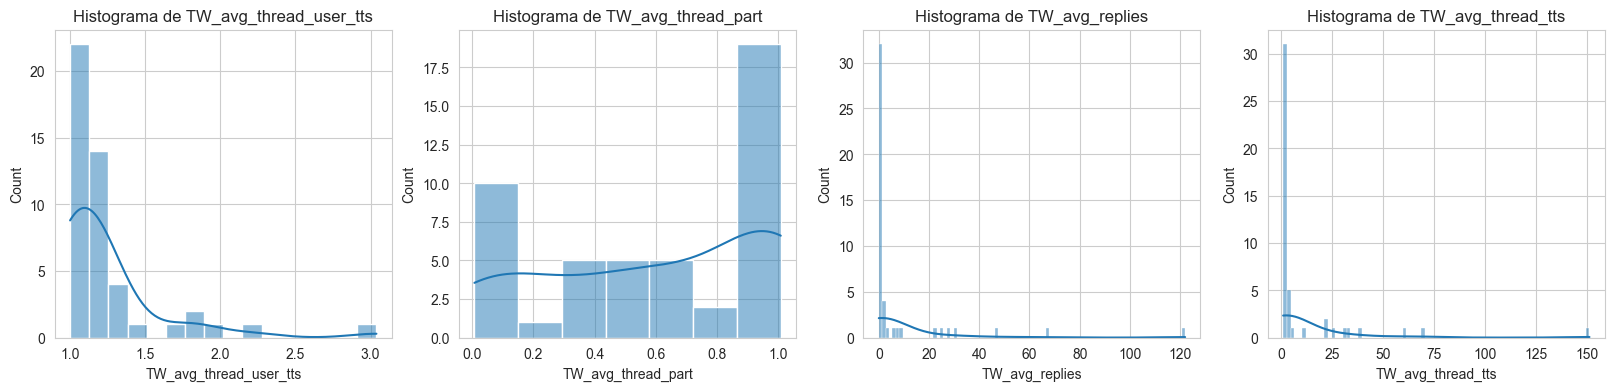

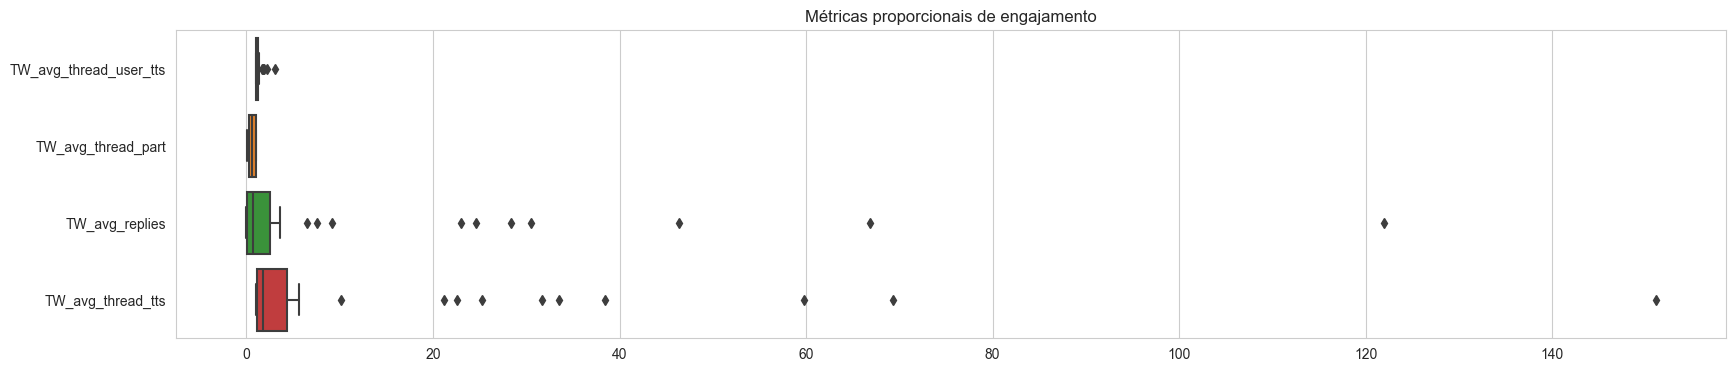

In [37]:
print_quant_data(cand_df, prop_activity_cols, 'TW_avg_thread_tts')
side_by_side(
    cand_df[['TW_USER', 'TW_avg_thread_user_tts']].sort_values('TW_avg_thread_user_tts', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_avg_thread_part']].sort_values('TW_avg_thread_part', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_avg_replies']].sort_values('TW_avg_replies', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_avg_thread_tts']].sort_values('TW_avg_thread_tts', ascending=False).head(5),
)
plot_cols(cand_df, prop_activity_cols, title=f'Métricas proporcionais de engajamento')

Avaliando tanto `TW_avg_thread_user_tts`, podemos concluir que os usuários analisados não participam muito das discussões em suas threads

... 

INCOMPLETO

### Correlação entre as Métricas de Engajamento 

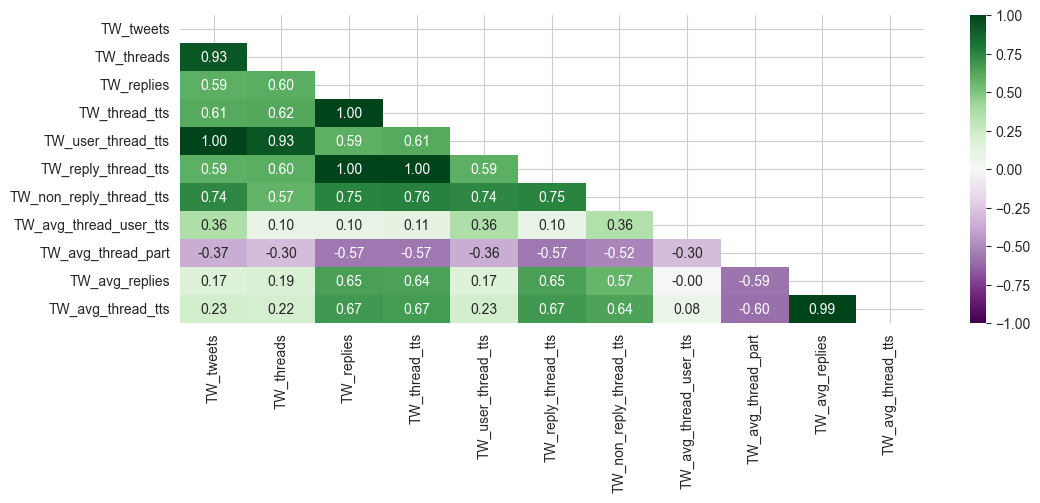

In [38]:
_df = cand_df[direct_activity_cols + thread_comp_cols + prop_activity_cols]
plot_corr_heatmap(_df)

... 

INCOMPLETO

### Métricas de conteúdo ofensivo

In [39]:
def get_user_offenses(user):
    """Quantidade de tweets ofensivos postados pelo usuário"""
    user_df = df[df['conversation_user'] == user]
    offenses = user_df[
        (user_df['class_label'] == True) &
        (user_df['user'] == user)
    ]
    return offenses.shape[0]

def get_reply_offenses(user):
    """Quantidade de replies ofensivas recebidas pelo usuário"""
    user_df = df[df['conversation_user'] == user]
    offenses = user_df[
        (user_df['class_label'] == True) &
        (user_df['in_reply_to_user'] == user)
    ]
    return offenses.shape[0]

def get_conversation_offenses(user):
    """Quantidade de tweets ofensivos postados em threads do usuário"""
    user_df = df[df['conversation_user'] == user]
    offenses = user_df[user_df['class_label'] == True]
    return offenses.shape[0]

cand_df['TW_user_offs'] = cand_df['TW_USER'].apply(get_user_offenses)
cand_df['TW_reply_offs'] = cand_df['TW_USER'].apply(get_reply_offenses)
cand_df['TW_thread_offs'] = cand_df['TW_USER'].apply(get_conversation_offenses)

offense_count_cols = ['TW_user_offs', 'TW_reply_offs', 'TW_thread_offs']

,TW_user_offs,TW_reply_offs,TW_thread_offs
count,47.000000,47.000000,47.000000
mean,15.404255,432.085106,447.340426
std,26.199618,1288.334682,1308.642364
min,0.000000,0.000000,0.000000
5%,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.500000
50%,5.000000,2.000000,10.000000
75%,15.500000,67.500000,94.000000
95%,75.100000,2006.800000,2031.300000
max,130.000000,7785.000000,7912.000000


,TW_USER,TW_user_offs
234,samiabomfim,130
734,carteiroreaca,87
826,valbolsonaro,82
957,bfeministapsol,59
861,andreawerner_,39
,TW_USER,TW_reply_offs
234,samiabomfim,7785
734,carteiroreaca,3455
994,rsallesmma,2290
403,marcofeliciano,1346


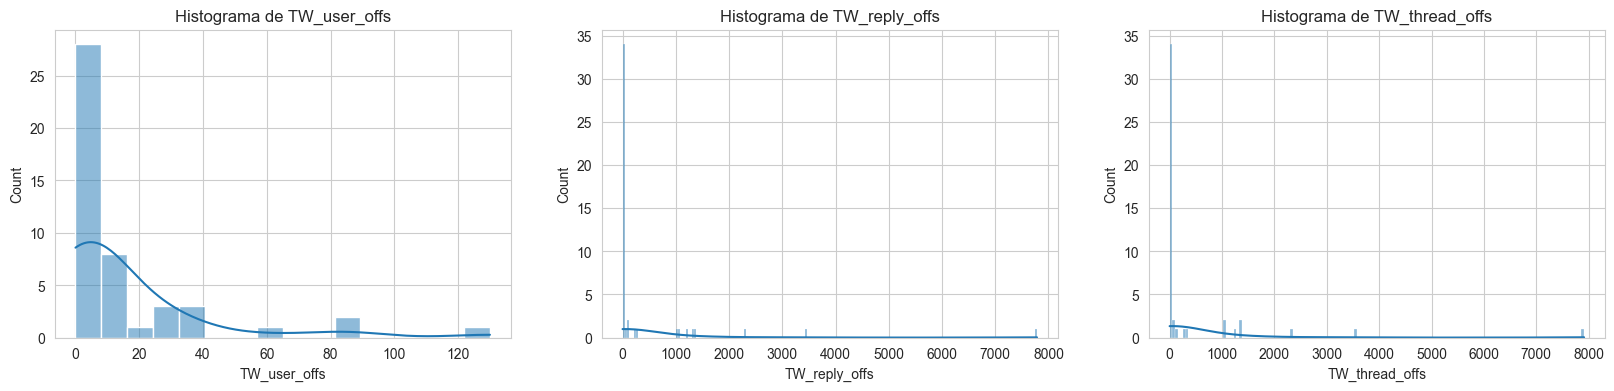

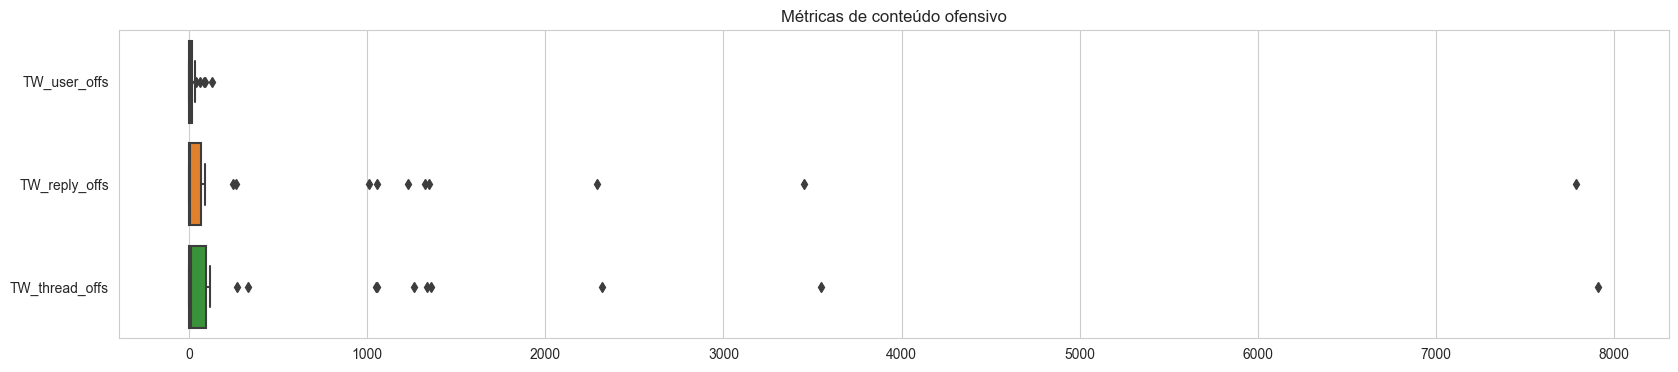

In [40]:
print_quant_data(cand_df, offense_count_cols, 'TW_thread_offs')

side_by_side(
    cand_df[['TW_USER', 'TW_user_offs']].sort_values('TW_user_offs', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_reply_offs']].sort_values('TW_reply_offs', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_thread_offs']].sort_values('TW_thread_offs', ascending=False).head(5),
)

plot_cols(cand_df, offense_count_cols, title=f'Métricas de conteúdo ofensivo')

Ao analisar a quantidade de conteudo ofensivo encontramos outliers de forma semelhante aos da análise anterior, o que pode apontar uma forte (e já esperada) correlação entre quantidade de tweets e de conteúdo ofensivo.

Vamos agora avaliar esta proporção.

In [41]:
"""Taxa de tweets ofensivos por thread do usuário"""
cand_df['TW_offs_per_thread'] = cand_df['TW_thread_offs'] / cand_df['TW_threads']

"""Taxa de tweets ofensivos pelo total de tweets postados pelo usuário"""
cand_df['TW_user_offs_rate'] = cand_df['TW_user_offs'] / cand_df['TW_tweets']

"""Taxa de replies ofensivas pelo total de replies recebidas pelo usuário"""
cand_df['TW_reply_offs_rate'] = cand_df['TW_reply_offs'] / cand_df['TW_replies']

"""Taxa de tweets ofensivos pelo total de tweets em threads do usuário"""
cand_df['TW_thread_offs_rate'] = cand_df['TW_thread_offs'] / cand_df['TW_thread_tts']

offense_prop_cols = ['TW_offs_per_thread', 'TW_user_offs_rate', 'TW_reply_offs_rate', 'TW_thread_offs_rate']

,TW_offs_per_thread,TW_user_offs_rate,TW_reply_offs_rate,TW_thread_offs_rate
count,47.000000,47.000000,44.000000,47.000000
mean,1.760102,0.065524,0.137808,0.088824
std,4.324779,0.068869,0.209042,0.067168
min,0.000000,0.000000,0.000000,0.000000
5%,0.000000,0.000000,0.000000,0.000000
25%,0.051667,0.000000,0.010714,0.036722
50%,0.120968,0.033448,0.099575,0.071429
75%,0.513200,0.124845,0.167446,0.142857
95%,10.497456,0.173200,0.320833,0.201792
max,22.735294,0.257862,1.000000,0.227053


,TW_USER,TW_offs_per_thread
994,rsallesmma,22.735294
403,marcofeliciano,14.020619
234,samiabomfim,11.987879
734,carteiroreaca,7.019802
113,pauloteixeira13,5.650224
,TW_USER,TW_user_offs_rate
826,valbolsonaro,0.257862
661,lucasbovesp,0.200000
994,rsallesmma,0.176000
1130,carlossampaio_,0.166667


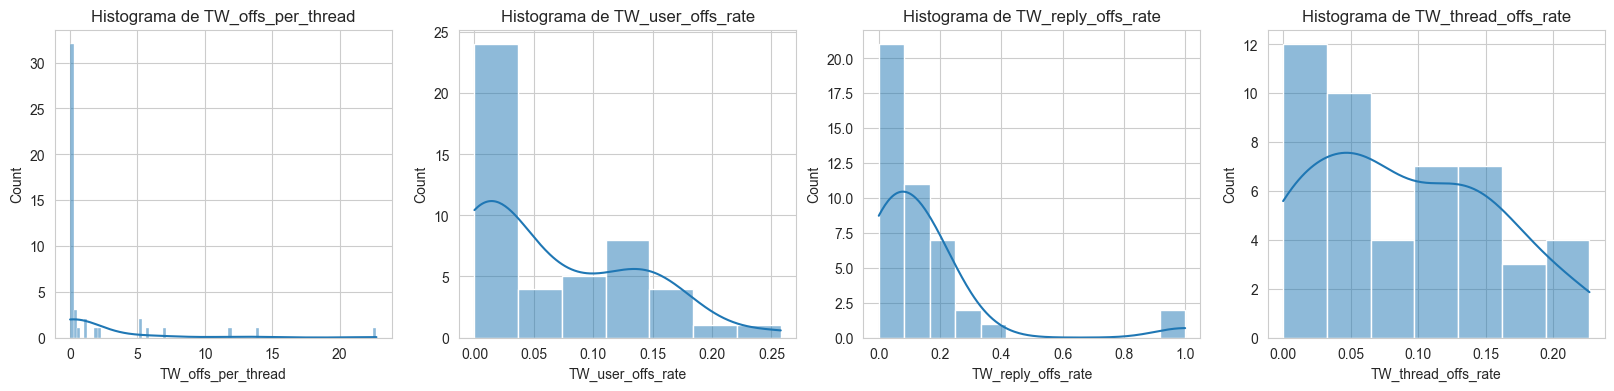

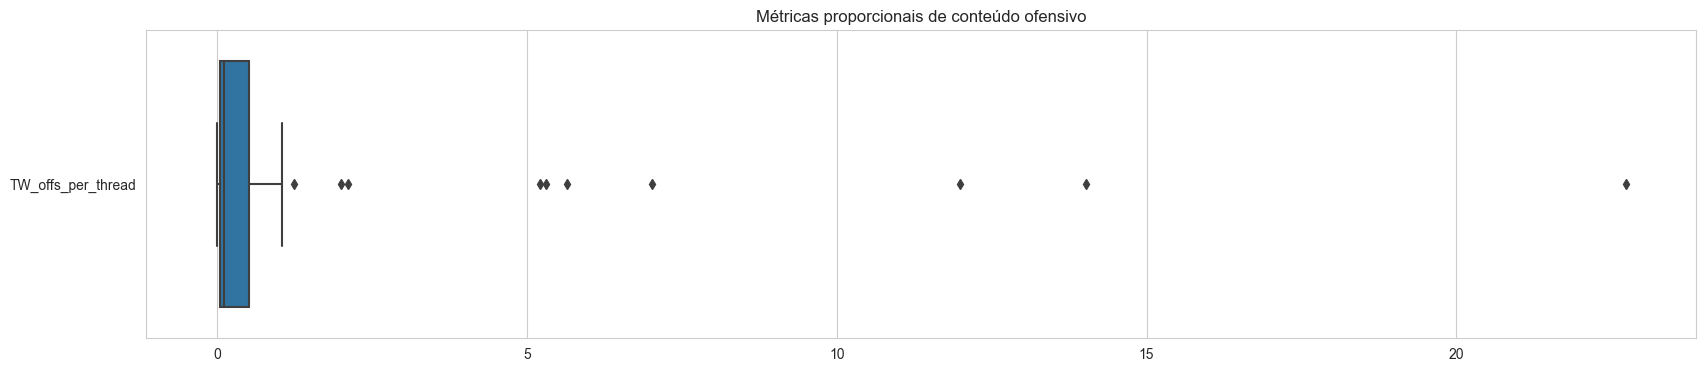

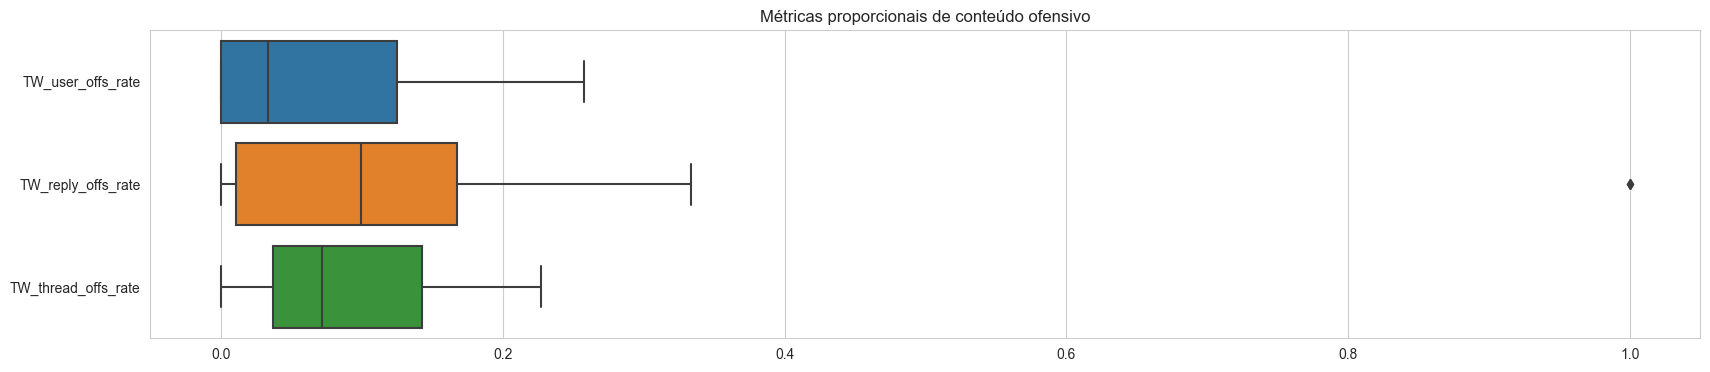

In [42]:
print_quant_data(
    cand_df, 
    offense_prop_cols, 
    'TW_thread_offs_rate'
)

side_by_side(
    cand_df[['TW_USER', 'TW_offs_per_thread']].sort_values('TW_offs_per_thread', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_user_offs_rate']].sort_values('TW_user_offs_rate', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_reply_offs_rate']].sort_values('TW_reply_offs_rate', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_thread_offs_rate']].sort_values('TW_thread_offs_rate', ascending=False).head(5),
)

plot_histograms(
    cand_df, 
    offense_prop_cols, 
)

plot_boxplots(
    cand_df, 
    [offense_prop_cols[0]], 
    title=f'Métricas proporcionais de conteúdo ofensivo',
)

plot_boxplots(
    cand_df, 
    offense_prop_cols[1:], 
    title=f'Métricas proporcionais de conteúdo ofensivo',
)

In [43]:
print(f"Distribuição de TW_offs_per_thread: \n{cand_df['TW_offs_per_thread'].value_counts(bins=5, normalize=True)}\n")

below_ten_prop = (cand_df[cand_df['TW_offs_per_thread'] <= 10].shape[0]) / (cand_df.shape[0])
print(f"{100*below_ten_prop:.2f}% dos candidatos tiveram até 10 tweets de conteúdo ofensivo por thread")

Distribuição de TW_offs_per_thread: 
(-0.023700000000000002, 4.547]    0.851064
(4.547, 9.094]                    0.085106
(9.094, 13.641]                   0.021277
(13.641, 18.188]                  0.021277
(18.188, 22.735]                  0.021277
Name: TW_offs_per_thread, dtype: float64

93.62% dos candidatos tiveram até 10 tweets de conteúdo ofensivo por thread


In [44]:
# print('Taxa de tweets ofensivos por thread do usuário')
# display(cand_df[["TW_USER"] + offense_prop_cols].sort_values('TW_offs_per_thread', ascending=False).head(5))

# print('\nTaxa de tweets ofensivos pelo total de tweets postados pelo usuário')
# display(cand_df[["TW_USER"] + offense_prop_cols].sort_values('TW_user_offs_rate', ascending=False).head(5))

# print('\nTaxa de replies ofensivas pelo total de replies recebidas pelo usuário')
# display(cand_df[["TW_USER"] + offense_prop_cols].sort_values('TW_reply_offs_rate', ascending=False).head(5))

# print('\nTaxa de tweets ofensivos pelo total de tweets em threads do usuário')
# display(cand_df[["TW_USER"] + offense_prop_cols].sort_values('TW_thread_offs_rate', ascending=False).head(5))

Ao considerarmos proporções ao invés de números absolutos as distribuições ficaram mais contínuas, diluindo o impacto dos outliers. 

Vamos agora avaliar a correlação entre estas variáveis para poder confirmar nossas suspeitas.

### Correlações entre métricas

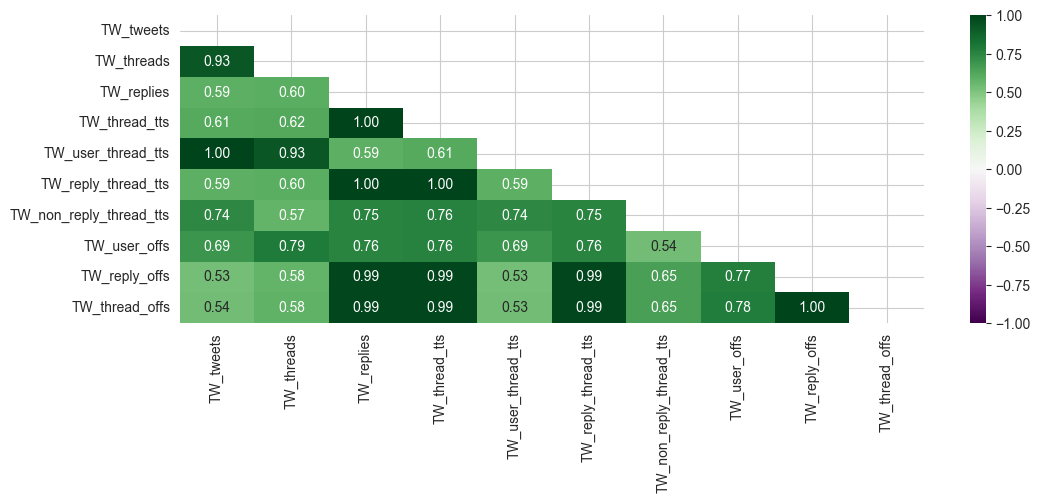

In [45]:
# Avaliando correlação entre os valores brutos
cols = [
    'TW_tweets', 'TW_threads', 'TW_replies', 'TW_thread_tts', 
    'TW_user_thread_tts', 'TW_reply_thread_tts', 'TW_non_reply_thread_tts', 
    'TW_user_offs', 'TW_reply_offs', 'TW_thread_offs'
]
_df = cand_df[cols]

plot_corr_heatmap(_df)

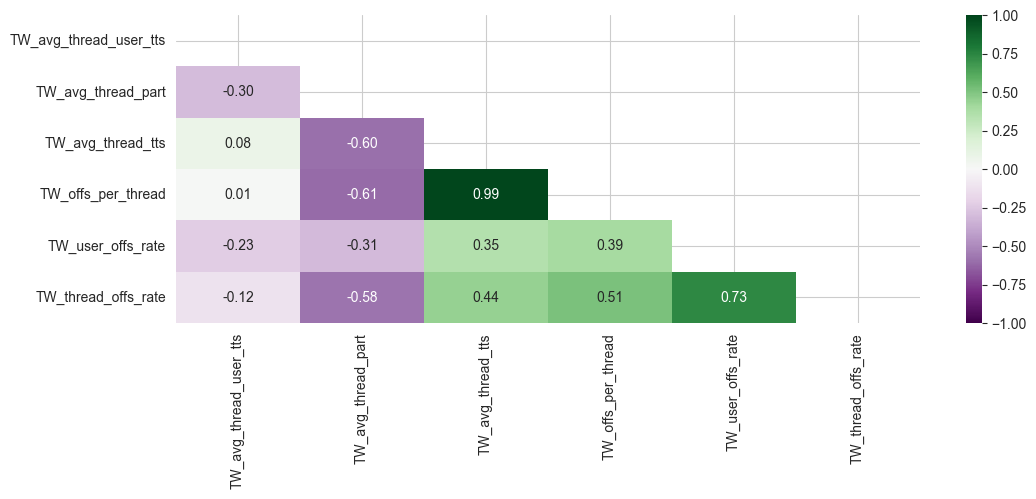

In [46]:
# Avaliando correlação entre as taxas
cols = [
    'TW_avg_thread_user_tts', 'TW_avg_thread_part', 'TW_avg_thread_tts', 
    'TW_offs_per_thread', 'TW_user_offs_rate', 'TW_thread_offs_rate', 
]
_df = cand_df[cols]

plot_corr_heatmap(_df)

Como esperado, encontramos correlações muito fortes entre a quantidade de tweets postados e a ocorrência de conteúdo ofensivo, tanto com relação a quantidade de threads abertas, quanto de tamanho das threads.

Mas que outras variáveis também podem estar correlacionadas com o conteúdo ofensivo?

# Analisando outras variáveis

In [47]:
cand_df.columns

Index(['SG_UF', 'DS_CARGO', 'SQ_CANDIDATO', 'NM_URNA_CANDIDATO', 'NR_PARTIDO',
       'SG_PARTIDO', 'NM_MUNICIPIO_NASCIMENTO', 'NR_IDADE_DATA_POSSE',
       'DS_GENERO', 'DS_GRAU_INSTRUCAO', 'DS_ESTADO_CIVIL', 'DS_COR_RACA',
       'DS_OCUPACAO', 'DS_SIT_TOT_TURNO', 'ST_REELEICAO', 'TW_USER',
       'TW_followersCount', 'TW_friendsCount', 'TW_statusesCount',
       'TW_favouritesCount', 'TW_tweets', 'TW_threads', 'TW_replies',
       'TW_thread_tts', 'TW_user_thread_tts', 'TW_reply_thread_tts',
       'TW_non_reply_thread_tts', 'TW_avg_thread_user_tts',
       'TW_avg_thread_part', 'TW_avg_replies', 'TW_avg_thread_tts',
       'TW_user_offs', 'TW_reply_offs', 'TW_thread_offs', 'TW_offs_per_thread',
       'TW_user_offs_rate', 'TW_reply_offs_rate', 'TW_thread_offs_rate'],
      dtype='object')

In [48]:
social_cols = ["DS_GENERO", "DS_COR_RACA", "DS_GRAU_INSTRUCAO"]

## Gênero

In [49]:
print(cand_df['DS_GENERO'].value_counts(normalize=True))

MASCULINO    0.702128
FEMININO     0.297872
Name: DS_GENERO, dtype: float64


In [50]:
# Teste T de Student para comparar a diferença entre as médias por gênero
_cols = direct_activity_cols + prop_activity_cols + thread_comp_cols + offense_count_cols + offense_prop_cols
alpha = 0.05
results = []
for col in _cols:
    male_sample = cand_df[cand_df['DS_GENERO'] == 'MASCULINO'][col]
    female_sample = cand_df[cand_df['DS_GENERO'] == 'FEMININO'][col]    
    t_stat, p_value = ttest_ind(male_sample, female_sample)
    result = {
        'col': col,
        't_stat': t_stat,
        'p_value': p_value,
        'sig_dif': bool(p_value <= alpha),
    }
    results.append(result)

ttest_df = pd.DataFrame(results)
ttest_df

,col,t_stat,p_value,sig_dif
0,TW_tweets,-3.062952,0.003693,True
1,TW_threads,-3.417776,0.001350,True
2,TW_replies,-1.179617,0.244351,False
3,TW_thread_tts,-1.255764,0.215683,False
4,TW_avg_thread_user_tts,-0.095263,0.924529,False
5,TW_avg_thread_part,0.910673,0.367320,False
6,TW_avg_replies,0.317278,0.752500,False
7,TW_avg_thread_tts,0.233587,0.816365,False
8,TW_user_thread_tts,-3.068556,0.003637,True
9,TW_reply_thread_tts,-1.180192,0.244125,False


In [51]:
dif_cols = list(ttest_df[ttest_df['sig_dif'] == True].col)
if dif_cols:
    print(f'Diferença significativa encontrada nas colunas: {dif_cols}')
else:
    print(f'Nenhuma coluna apresentou diferença significativa')

Diferença significativa encontrada nas colunas: ['TW_tweets', 'TW_threads', 'TW_user_thread_tts', 'TW_user_offs']


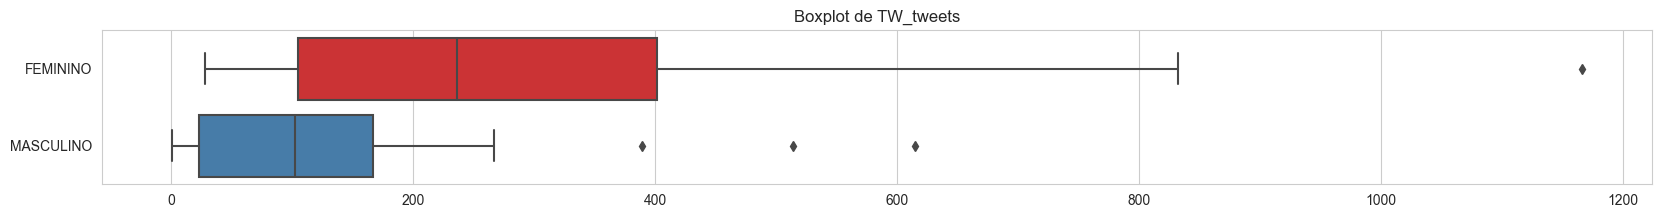

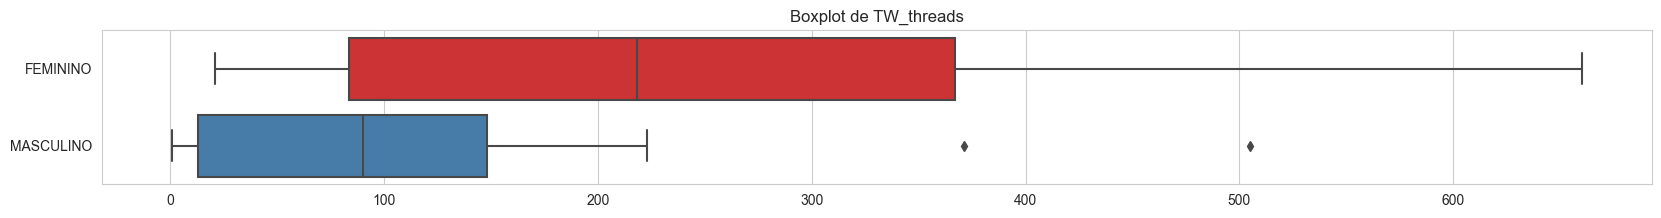

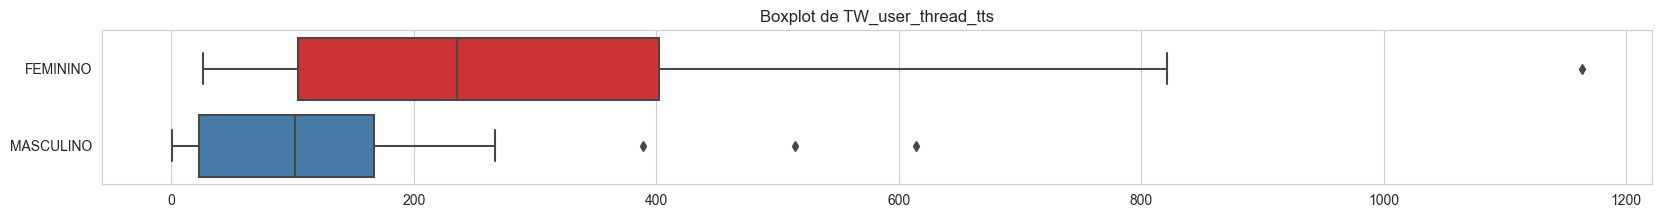

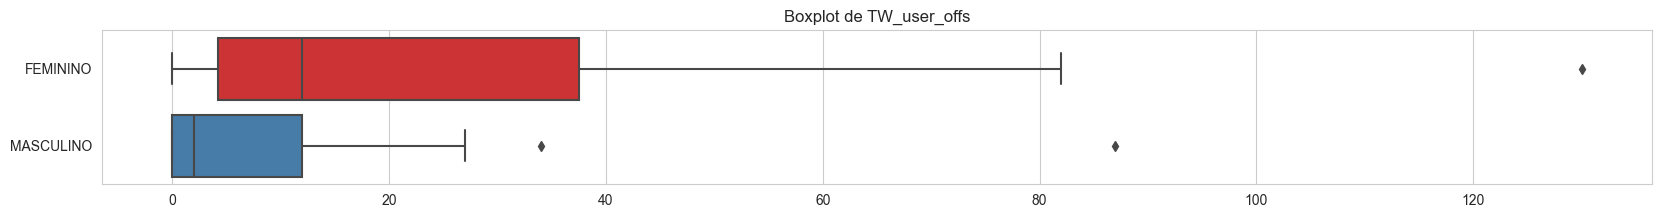

In [52]:
for i, col in enumerate(dif_cols):
    plt.figure(figsize=(20, 2))
    p = sns.boxplot(
        data=cand_df[social_cols + dif_cols],
        x=col,
        y='DS_GENERO',
        order=['FEMININO', 'MASCULINO'],
        palette='Set1',
    )
    p.set(
        title=f'Boxplot de {col}', xlabel=None, ylabel=None,
    )
    plt.show()

Foram encontradas diferenças significativas em 2 métricas diretas de atividade no Twitter: `TW_tweets` e `TW_threads`.

Também foram encontradas diferenças em `TW_user_thread_tts` (razão entre tweets do usuario e total de tweets em suas threads) e `TW_user_offs` (quantidade de tweets do usuário com conteúdo ofensivo)

## Cor/Raça

In [53]:
print(cand_df['DS_COR_RACA'].value_counts())

BRANCA      40
PRETA        4
PARDA        2
INDÍGENA     1
Name: DS_COR_RACA, dtype: int64


In [54]:
# Como as classes estão desbalanceadas, vamos agrupar PRETA, PARDA e INDÍGENA como NAO-BRANCA
def get_simplified_color(color):
    if color != 'BRANCA':
        return 'NAO-BRANCA'
    return color

cand_df['DS_COR_RACA_SIMP'] = cand_df['DS_COR_RACA'].apply(get_simplified_color)
print(cand_df['DS_COR_RACA_SIMP'].value_counts())

BRANCA        40
NAO-BRANCA     7
Name: DS_COR_RACA_SIMP, dtype: int64


In [55]:
# Teste T de Student para comparar a diferença entre as médias por cor/raça
_cols = direct_activity_cols + prop_activity_cols + thread_comp_cols + offense_count_cols + offense_prop_cols
alpha = 0.05
results = []
for col in _cols:
    white_sample = cand_df[cand_df['DS_COR_RACA_SIMP'] == 'BRANCA'][col]
    non_white_sample = cand_df[cand_df['DS_COR_RACA_SIMP'] == 'NAO-BRANCA'][col]    
    t_stat, p_value = ttest_ind(white_sample, non_white_sample)
    result = {
        'col': col,
        't_stat': t_stat,
        'p_value': p_value,
        'sig_dif': bool(p_value <= alpha),
    }
    results.append(result)

ttest_df = pd.DataFrame(results)
ttest_df

,col,t_stat,p_value,sig_dif
0,TW_tweets,0.639327,0.525851,False
1,TW_threads,0.487789,0.628067,False
2,TW_replies,1.017744,0.314240,False
3,TW_thread_tts,1.017809,0.314210,False
4,TW_avg_thread_user_tts,-0.250859,0.803065,False
5,TW_avg_thread_part,-0.922535,0.361170,False
6,TW_avg_replies,1.003918,0.320786,False
7,TW_avg_thread_tts,1.027161,0.309834,False
8,TW_user_thread_tts,0.634576,0.528918,False
9,TW_reply_thread_tts,1.016248,0.314944,False


In [56]:
dif_cols = list(ttest_df[ttest_df['sig_dif'] == True].col)
if dif_cols:
    print(f'Diferença significativa encontrada nas colunas: {dif_cols}')
else:
    print(f'Nenhuma coluna apresentou diferença significativa')

Nenhuma coluna apresentou diferença significativa


## Grau/Instrução

In [57]:
print(cand_df['DS_GRAU_INSTRUCAO'].value_counts())

SUPERIOR COMPLETO                44
SUPERIOR INCOMPLETO               2
ENSINO FUNDAMENTAL INCOMPLETO     1
Name: DS_GRAU_INSTRUCAO, dtype: int64


Os dados de DS_GRAU_INSTRUCAO estão muito desbalanceados, portanto não podemos fazer análises sobre eles

# Conclusão

**Correlações entre as métricas:**
- TW_avg_thread_part e -TW_offs_per_thread
- TW_avg_thread_part e -TW_thread_offs_rate

**Diferenças significativas entre categorias:**
- DS_GENERO e TW_tweets
- DS_GENERO e TW_threads
- DS_GENERO e TW_user_thread_tts
- DS_GENERO e TW_user_offs